Code for the U-turn simulation model figures in PRL draft

Jan 1, 2025 by CKC

Jan 4, 2025 used DeepSeek to optimize the modules

Jan 24, 2025 preparation for public release


In [1]:
# Here are the general purpose routines

# TLMI from CCC
# the d is the list of time lag between a and b
# bn in the resolution of discritization in number of bits

def mi_quick(a,b,d,bn):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

# Auto and cross TLMI using mi_quik
# dms is a list of time lag

def MI(A, B, dms, n_state):
    # A and B are list of real numbers
    mi_AA = [mi_quick(A,A,d,n_state) for d in dms]
    mi_AB = [mi_quick(A,B,d,n_state) for d in dms]
    mi_BB = [mi_quick(B,B,d,n_state) for d in dms]
    mi_all = [mi_AA, mi_AB, mi_BB]
    return mi_all

# Smooth function from ChatGPT4
def smooth_array(A, N=3):
    # Ensure N is odd to have a symmetrical window
    if N % 2 == 0:
        N += 1

    # Create a window: simple moving average
    window = np.ones(int(N))/float(N)
    
    # Apply convolution to smooth the array
    # Mode 'same' returns the convolution at each point of the original array
    smooth_A = np.convolve(A, window, 'same')
    
    return smooth_A


# Detrend function = original array - smoothed version
# N is the smoothing window 
def detrend(A,N):
    A = A - smooth_array(A,N)
    A[0:N] = 0
    A[-N:] = 0
    return A

In [2]:
import numpy as np  # Ensure numpy is imported for random number generation

# Class to simulate U-turn behavior of two particles (p1 and p2)
class UturnSimulation:
    def __init__(self, ucount, a1, b1, a2, b2, prob1, prob2, d_min, p2_enforce_ut_delay, debug):
        """
        Initialize the U-turn simulation with the given parameters.

        :param ucount: Time elapsed after a U-turn
        :param a1, b1: Region boundaries for spontaneous U-turn of p1
        :param a2, b2: Region boundaries for spontaneous U-turn of p2
        :param prob1, prob2: Probability of spontaneous U-turn for p1 and p2
        :param d_min: Minimum distance between p1 and p2 to enforce separation
        :param p2_enforce_ut_delay: Delay before p2 responds to p1's U-turn
        :param debug: Debug flag (1 for debug mode, 0 otherwise)
        """
        self.ucount = ucount
        self.uturn_duration = int(ucount / 2)  # Duration of a U-turn
        self.a1, self.b1 = a1, b1  # U-turn region for p1
        self.a2, self.b2 = a2, b2  # U-turn region for p2
        self.prob1, self.prob2 = prob1, prob2  # U-turn probabilities
        self.d_min = d_min  # Minimum separation distance
        self.p1u_count, self.p2u_count = 0, 0  # U-turn counters for p1 and p2
        self.count = 0  # System counter
        self.p1_uflag = 0  # Flag to track if p1 has performed a U-turn
        self.p1_utime = 65535  # Time when p1 performed a U-turn (initialized to a large number)
        self.p2_enforce_ut_delay = p2_enforce_ut_delay  # Delay for p2's response to p1's U-turn
        self.debug = debug  # Debug mode flag

    def enforce_boundary(self, p1, p2, d1, d2):
        """
        Ensure particles stay within the [0, 1] boundary and reverse direction if they hit the boundary.

        :param p1, p2: Positions of particles p1 and p2
        :param d1, d2: Directions of particles p1 and p2 (-1 or +1)
        :return: Updated positions and directions of p1 and p2
        """
        # Check boundaries for p1
        if p1 >= 1:
            p1, d1 = 1, -1
            self.p1u_count = 0  # Reset U-turn counter
            if self.debug:
                print('1 Boundary enforced for p1')
        elif p1 <= 0:
            p1, d1 = 0, 1
            self.p1u_count = 0
            if self.debug:
                print('0 Boundary enforced for p1')

        # Check boundaries for p2
        if p2 >= 1:
            p2, d2 = 1, -1
            self.p2u_count = 0
            if self.debug:
                print('1 Boundary enforced for p2')
        elif p2 <= 0:
            p2, d2 = 0, 1
            self.p2u_count = 0
            if self.debug:
                print('0 Boundary enforced for p2')

        return p1, p2, d1, d2

    def counters_dec(self):
        """Decrement U-turn counters for p1 and p2 if they are active."""
        if self.p1u_count > 0:
            self.p1u_count -= 1
        if self.p2u_count > 0:
            self.p2u_count -= 1

    def enforce_direction(self, d1, d2):
        """
        Enforce leader-follower relationship between p1 and p2 during U-turn.

        :param d1, d2: Directions of p1 and p2
        :return: Updated directions of p1 and p2
        """
        if d1 != d2 and self.ucount < self.uturn_duration:
            d2 = -d2  # Reverse direction of p2
            if self.debug:
                print('Direction reversal enforced for p2')
        return d1, d2

    def p2_uturn(self, d2):
        """
        Execute a U-turn for p2 if its U-turn counter is zero.

        :param d2: Direction of p2
        :return: Updated direction of p2
        """
        if self.p2u_count == 0:
            self.p2u_count = self.ucount  # Set U-turn counter
            d2 = -d2  # Reverse direction
            if self.debug:
                print('p2 U-turn executed')
        return d2

    def p1_uturn(self, d1):
        """
        Execute a U-turn for p1 if its U-turn counter is zero.

        :param d1: Direction of p1
        :return: Updated direction of p1
        """
        if self.p1u_count == 0:
            self.p1u_count = self.ucount  # Set U-turn counter
            d1 = -d1  # Reverse direction
            if self.debug:
                print('p1 U-turn executed')
        return d1

    def enforce_separation(self, p1, p2, d1, d2):
        """
        Enforce minimum separation distance between p1 and p2.

        :param p1, p2: Positions of p1 and p2
        :param d1, d2: Directions of p1 and p2
        :return: Updated direction of p2
        """
        if (d1 == 1 and d2 == 1 and p1 < p2 + self.d_min) or (d1 == -1 and d2 == -1 and p1 > p2 - self.d_min):
            d2 = self.p2_uturn(d2)  # Enforce U-turn for p2
            if self.debug:
                print('Separation enforced for p2')
        return d2

    def spon_uturn(self, p1, p2, d1, d2):
        """
        Perform spontaneous U-turns for p1 based on probability and position.

        :param p1, p2: Positions of p1 and p2
        :param d1, d2: Directions of p1 and p2
        :return: Updated directions of p1 and p2
        """
        if not (self.a1 < p1 < self.b1) and self.p1u_count == 0:
            if self.prob1 > np.random.uniform(0, 1):  # Random U-turn based on probability
                d1 = -d1
                self.p1u_count = self.ucount
                self.p1_utime = self.count
                self.p1_uflag = 1  # Set U-turn flag
                if self.debug:
                    print('Spontaneous U-turn for p1')
        return d1, d2

    def enforce_2nd_Uturn(self, d1, d2):
        """
        Enforce a second U-turn for p1 or p2 if their U-turn counter reaches half the duration.

        :param d1, d2: Directions of p1 and p2
        :return: Updated directions of p1 and p2
        """
        if self.p1u_count == self.uturn_duration:
            d1 = -d1
            if self.debug:
                print('Second U-turn for p1')
        if self.p2u_count == self.uturn_duration:
            d2 = -d2
            if self.debug:
                print('Second U-turn for p2')
        return d1, d2

    def p2_response(self, p1, p2, d1, d2):
        """
        Enforce p2's response to p1's U-turn after a specified delay.

        :param p1, p2: Positions of p1 and p2
        :param d1, d2: Directions of p1 and p2
        :return: Updated direction of p2
        """
        if (self.p1_uflag == 1 and self.count - self.p1_utime >= self.p2_enforce_ut_delay and
                self.p2u_count == 0 and abs(p1 - p2) < self.d_min):
            d2 = self.p2_uturn(d2)  # Enforce U-turn for p2
            self.p1_uflag = 0  # Reset U-turn flag
            if self.debug:
                print('p2 U-turn enforced in response to p1')
        return d2

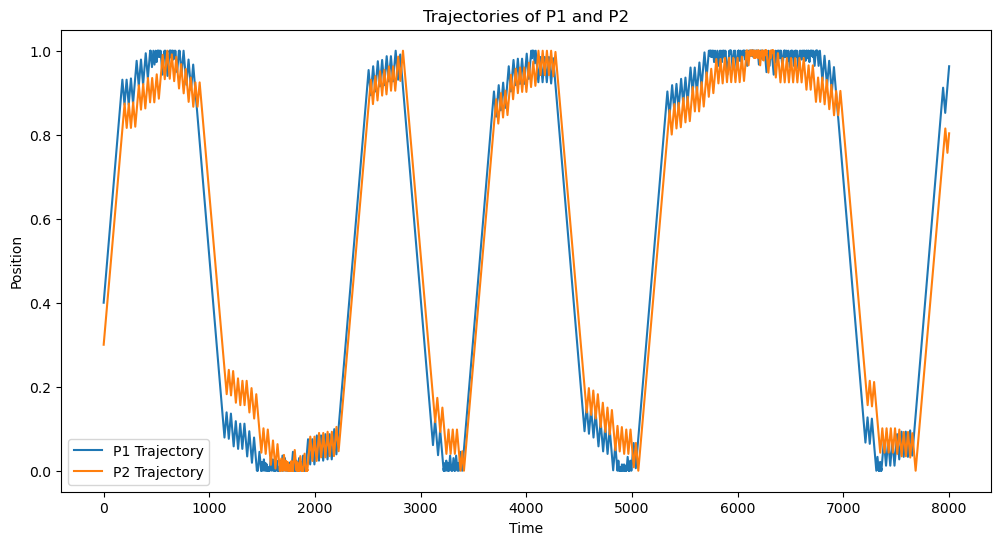

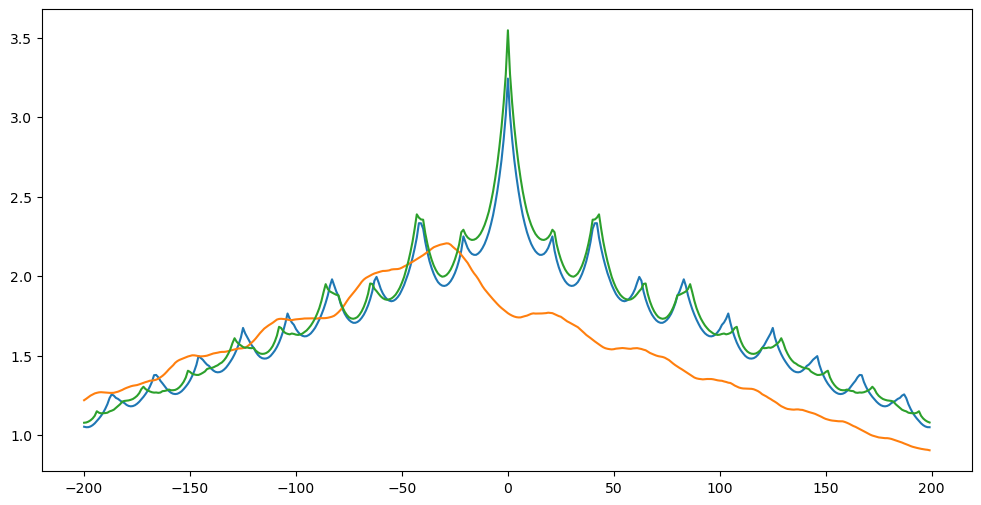

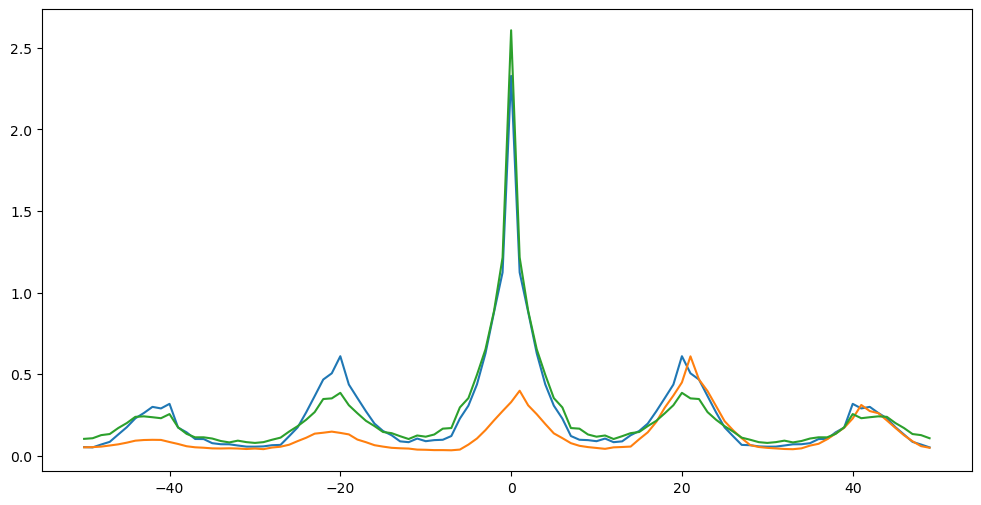

In [3]:
# Simulation for small d

import numpy as np
import matplotlib.pyplot as plt

# set debug to 1 to see plotting for different cases and
# values of different variables during simulation

debug = 0

# simulation parameters
time_step = 1     # Time step for the simulation
n_steps = 8000

# physical parameters
# Particle speeds and positions
s1 = 0.003  # Speed of particle P1
s2 = 0.0029 # Speed of particle P2

# slow-down zone
# regions where spontaneous uturn CANNOT happen:
# [a1,b1] and [a2,b2] for p1 and p2 respectively
a1 = 0.1 
b1 = 0.9
a2 = 0.1
b2 = 0.9

prob1 = 0.15 # spontaneous uturn probability for p1
prob2 = 0.0  # spontaneous uturn probability for p2

# 2UT total duration is ucount
ucount = 40
uturn_duration = int(ucount/2) # duration of one single UT
d_min = 0.05 # minimal distance the follwer should enforce

# Initial random positions within [0, 1]
pos1 = 0.4
pos2 = 0.3

# initial direction of motion (1 for right, -1 for left)
direction1 = 1
direction2 = 1

# Lists to store positions and time
positions1 = [pos1]
positions2 = [pos2]
time = [0]

# initialization of counters and flags
count = 0 # simulation step counter
p1u_count = 0 # UT counter for p1
p2u_count = 0 # UT counter for p2

p1_uflag = 0 # a flag to indication the ocurrence of 2UT for p1
p1_utime = 0 # time stamp of the last 2UT of p1


# response of p2 to p1 uturn delay
p2_enforce_ut_delay = 13


ut_sim = UturnSimulation(ucount, a1, b1, a2, b2, prob1, prob2, d_min, p2_enforce_ut_delay,debug)

# Simulation loop
for t in range(1, n_steps + 1):
    count += 1 # update system counter
    # Update positions
    pos1 += direction1 * s1 * time_step
    pos2 += direction2 * s2 * time_step
        
    if p2u_count == 0: # enforce LFR when p2 is not in 2UT
    #   check p1 p2 distance and change direction of p2 if 
        direction2 = ut_sim.enforce_separation(pos1,pos2,direction1,direction2)
    #   check if the leader-follower relation is followed, change direction if needed
        direction1,direction2 = ut_sim.enforce_direction(direction1,direction2)

    # check if spontaneous uturns are performed for p1
    direction1,direction2 = ut_sim.spon_uturn(pos1,pos2,direction1,direction2)

    # Enforce of 2nd U-turn
    direction1,direction2 = ut_sim.enforce_2nd_Uturn(direction1,direction2)

    # check if p1 and p2 are out of [0,1]; bring them back and reverse direction if needed
    pos1,pos2,direction1,direction2 = ut_sim.enforce_boundary(pos1,pos2,direction1,direction2)

    # check if p1 triggered U-turn of p2
    direction2 = ut_sim.p2_response(pos1,pos2,direction1,direction2)
    
    # decrease the u-turn counters if they are set
    ut_sim.counters_dec()

    # save current positions to the lists
    positions1.append(pos1)
    positions2.append(pos2)
    time.append(t * time_step)
    if debug ==1: 
        print(count,pos1,pos2, direction1,direction2,p1u_count,p2u_count,p1_uflag,p1_utime)

# Plotting the trajectories
plt.figure(figsize = (12,6))
plt.plot(time, positions1, label='P1 Trajectory')
plt.plot(time, positions2, label='P2 Trajectory')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Trajectories of P1 and P2')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
A = positions1
B = positions2
dms = range(-200, 200, 1)
n_state = 16
mi_12= MI(A, B, dms, n_state)
for i in range(3):
    plt.plot(dms,mi_12[i])
#plt.xlim(-100,100)
plt.show()

plt.figure(figsize=(12,6))
A = detrend(positions1,10)
B = detrend(positions2,10)
ddms = range(-50, 50, 1)
n_state = 16
mmi_12= MI(B, A, ddms, n_state)
for i in range(3):
    plt.plot(ddms,mmi_12[i])
#plt.xlim(-100,100)
plt.show()

# store and switch 1 and 2 to be consisten with experiment
pp1 = positions2
pp2 = positions1

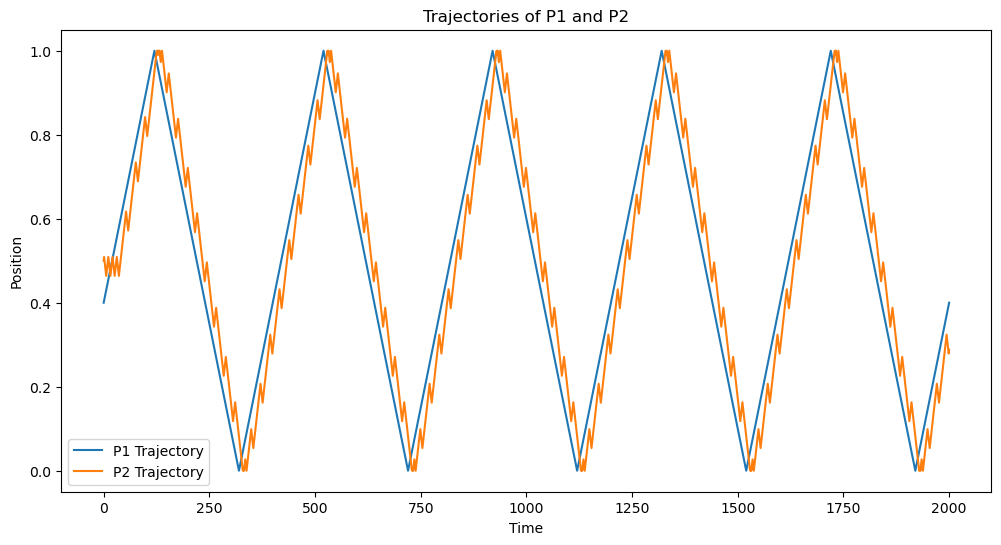

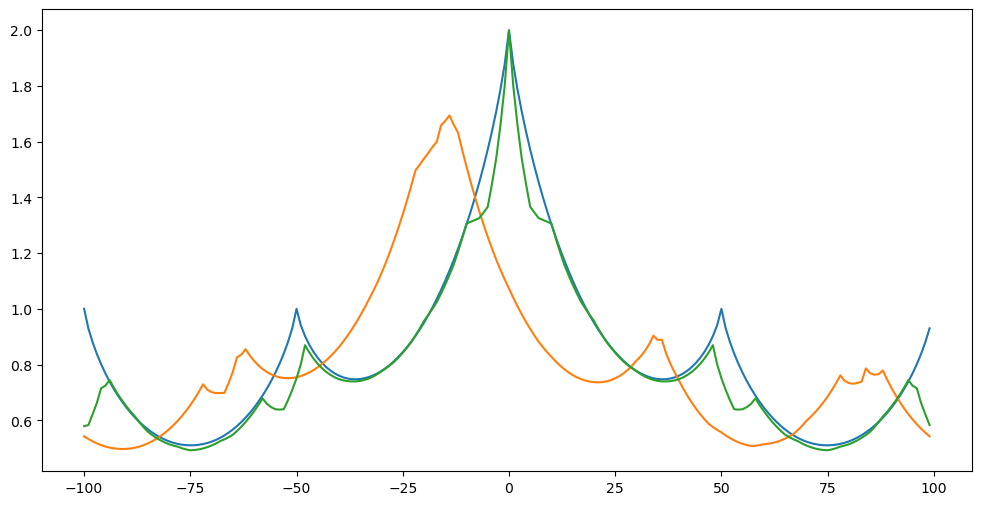

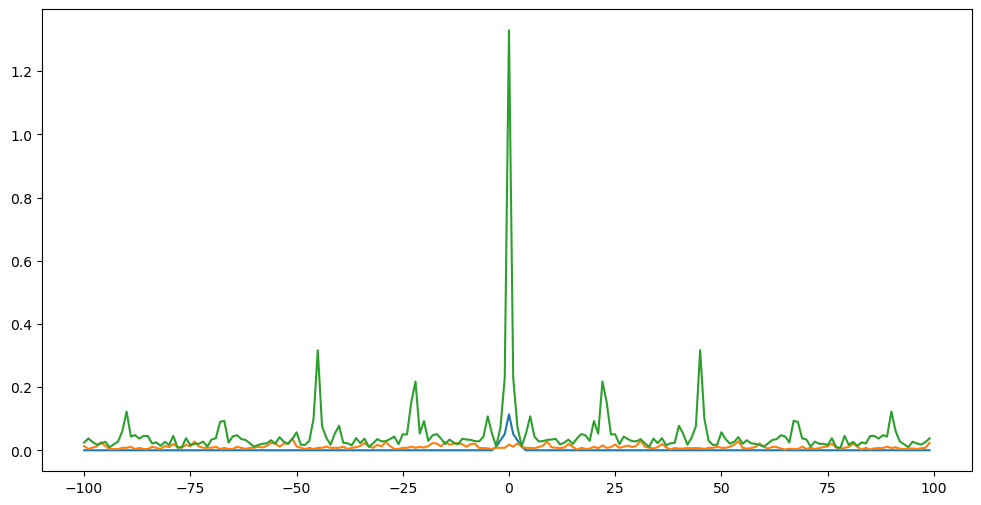

In [4]:
# create simulation data for the case of large d

import numpy as np
import matplotlib.pyplot as plt

# fish 1 and fish 2 are interchanged from those from experiemnts
# fish 1 is the leader

# Parameters
total_time = 2000  # Total time for the simulation
time_step = 1     # Time step for the simulation
n_steps = int(total_time / time_step)

# Particle speeds and positions
s1 = 0.005  # Speed of particle P1
s2 = 0.009  # Speed of particle P2

a1 = 0.1
b1 = 0.9
a2 = 0.0
b2 = 0.0

prob1 = 0.0
prob2 = 0.0

ucount = 10
uturn_duration = int(ucount/2)
d_min = 0.05
delay = 1

# Initial random positions within [0, 1]
pos1 = np.random.uniform(0, 1)
pos2 = np.random.uniform(0, 1)

pos1 = 0.4
pos2 = 0.5

# Direction of motion (1 for increasing direction, -1 for decreasing direction)
direction1 = 1
direction2 = 1

# Lists to store positions over time
positions1 = [pos1]
positions2 = [pos2]
time = [0]

# counters
count = 0
p1u_count = 0
p2u_count = 0

ut_sim = UturnSimulation(ucount, a1, b1, a2, b2, prob1, prob2, d_min, p2_enforce_ut_delay,debug)

# Simulation loop
for t in range(1, n_steps + 1):
    count += 1 # update system counter
    # Update positions
    pos1 += direction1 * s1 * time_step
    pos2 += direction2 * s2 * time_step
        
    if p2u_count == 0: # enforce LFR when p2 is not in 2UT
    #   check p1 p2 distance and change direction of p2 if 
        direction2 = ut_sim.enforce_separation(pos1,pos2,direction1,direction2)
    #   check if the leader-follower relation is followed, change direction if needed
        direction1,direction2 = ut_sim.enforce_direction(direction1,direction2)

    # check if spontaneous uturns are performed for p1
    direction1,direction2 = ut_sim.spon_uturn(pos1,pos2,direction1,direction2)

    # Enforce of 2nd U-turn
    direction1,direction2 = ut_sim.enforce_2nd_Uturn(direction1,direction2)

    # check if p1 and p2 are out of [0,1]; bring them back and reverse direction if needed
    pos1,pos2,direction1,direction2 = ut_sim.enforce_boundary(pos1,pos2,direction1,direction2)

    # check if p1 triggered U-turn of p2
    direction2 = ut_sim.p2_response(pos1,pos2,direction1,direction2)
    
    # decrease the u-turn counters if they are set
    ut_sim.counters_dec()

    # save current positions to the lists
    positions1.append(pos1)
    positions2.append(pos2)
    time.append(t * time_step)
    if debug ==1: 
        print(count,pos1,pos2, direction1,direction2,p1u_count,p2u_count,p1_uflag,p1_utime)

# Plotting the trajectories
plt.figure(figsize = (12,6))
plt.plot(time, positions1, label='P1 Trajectory')
plt.plot(time, positions2, label='P2 Trajectory')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Trajectories of P1 and P2')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
A = positions1
B = positions2
dms = range(-100, 100, 1)
n_state = 4
mi_12= MI(A, B, dms, n_state)
for i in range(3):
    plt.plot(dms,mi_12[i])
#plt.xlim(-100,100)
plt.show()

plt.figure(figsize=(12,6))
dms = range(-100, 100, 1)
A = detrend(positions1,5)
B = detrend(positions2,5)*100

mi_12= MI(A, B, dms, n_state)
for i in range(3):
    plt.plot(dms,mi_12[i])
#plt.xlim(-100,100)
plt.show()

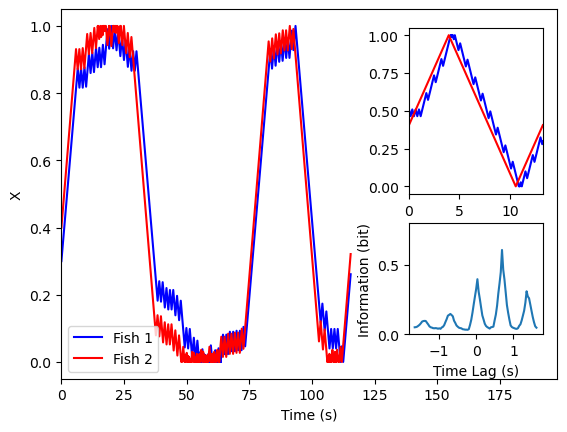

In [5]:
# creation for figure 5 of the PRL draft
# Fish 1 and Fish 2 are the same as the experiment now
# We set the time scale for one simulation step here so that
# the time scales look similar to those from experimental results

# Create the main plot
fig, ax_main = plt.subplots()
pos = 3500
time_scale = 0.033 # time scale of one simulation step
t_axis = np.arange(0, 3500)*time_scale
ax_main.plot(t_axis,pp1[0:pos], label='Fish 1', color='blue')
ax_main.plot(t_axis,pp2[0:pos], label='Fish 2', color='red')
ax_main.set_xlim(0,6000*time_scale)
ax_main.set_xlabel('Time (s)')
ax_main.set_ylabel('X')
ax_main.legend()
ax_main.legend(loc='lower left') 

# Remove grid from the main plot
ax_main.grid(False)

# Create an inset
inset = ax_main.inset_axes([0.7, 0.12, 0.27, 0.3])  # [x0, y0, width, height]

# inset.set_xlim(100,140)


inset.plot(np.array(ddms)*time_scale,mmi_12[1],label=str(i)+' cm')

inset.patch.set_alpha(0.7)
#inset.set_title('Fish 1')
inset.set_ylim(0,0.8)
inset.set_xlabel('Time Lag (s)')
inset.set_ylabel('Information (bit)')


# Remove grid from the inset plot
inset.grid(False)

# Create an inset
inset2 = ax_main.inset_axes([0.7, 0.5, 0.27, 0.45])  # [x0, y0, width, height]

# inset.set_xlim(100,140)

# note the interchange of 1 and 2 to agree with the experiment


time_scale = 0.033
t2_axis = np.arange(0, len(positions1))*time_scale
inset2.plot(t2_axis,positions2, label='Fish 1', color='blue')
inset2.plot(t2_axis,positions1, label='Fish 2', color='red')

inset2.patch.set_alpha(0.7)
inset2.set_xlim(0,400*time_scale)



# Remove grid from the inset plot
inset2.grid(False)

#output of pdf for the figure with the name "Sim_d0.pdf"
plt.savefig("Sim_data.pdf", format="pdf", bbox_inches="tight")
plt.show()